In [2]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [3]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
train_set = MNIST(root="../datasets", train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST(root="../datasets", train=False, download=True, transform=transforms.ToTensor())

In [59]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=50, shuffle=False)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2, padding=1)
        )

        self.latent = nn.Linear(in_features=32 * 7 * 7, out_features=128)
        self.fc_decoder = nn.Linear(in_features=128, out_features=32 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16,
                               kernel_size=3, stride=2, padding=1, 
                               output_padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1,
                               kernel_size=3, padding=1,
                               output_padding=1, stride=2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        
        latent_vector = self.latent(encoded.reshape(x.shape[0], -1))
        decoded_flat = self.fc_decoder(latent_vector)
        decoded = decoded_flat.view(-1, 32, 7, 7)

        decoded = self.decoder(encoded)
        
        return decoded, latent_vector

In [6]:
model = AutoEncoder().to(DEVICE)

In [7]:
NUM_EPOCH = 15
LEARNING_RATE = 1e-4

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [11]:
min_loss = float('inf')
train_loss = []

for epoch in range(NUM_EPOCH):

    total_loss = 0

    for img, _ in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        img = img.to(DEVICE)
        out, _ = model(img)

        loss = criterion(out, img)

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_loader)
    train_loss.append(epoch_loss)

    print(f'Epoch: {epoch + 1} | Loss: {epoch_loss:.4f}')

    if epoch_loss < min_loss:
        torch.save(model.state_dict(), "./best_model.pth")
        torch.save(optimizer.state_dict(), "./optimizer_state.pth")
        min_loss = epoch_loss

Epoch 1: 100%|██████████| 938/938 [00:18<00:00, 51.57it/s]


Epoch: 1 | Loss: 0.0904


Epoch 2: 100%|██████████| 938/938 [00:17<00:00, 53.04it/s]


Epoch: 2 | Loss: 0.0183


Epoch 3: 100%|██████████| 938/938 [00:17<00:00, 54.01it/s]


Epoch: 3 | Loss: 0.0066


Epoch 4: 100%|██████████| 938/938 [00:17<00:00, 52.94it/s]


Epoch: 4 | Loss: 0.0032


Epoch 5: 100%|██████████| 938/938 [00:17<00:00, 52.30it/s]


Epoch: 5 | Loss: 0.0019


Epoch 6: 100%|██████████| 938/938 [00:17<00:00, 53.12it/s]


Epoch: 6 | Loss: 0.0013


Epoch 7: 100%|██████████| 938/938 [00:16<00:00, 57.19it/s]


Epoch: 7 | Loss: 0.0009


Epoch 8: 100%|██████████| 938/938 [00:17<00:00, 54.73it/s]


Epoch: 8 | Loss: 0.0008


Epoch 9: 100%|██████████| 938/938 [00:16<00:00, 58.62it/s]


Epoch: 9 | Loss: 0.0007


Epoch 10: 100%|██████████| 938/938 [00:17<00:00, 54.38it/s]


Epoch: 10 | Loss: 0.0006


Epoch 11: 100%|██████████| 938/938 [00:17<00:00, 54.19it/s]


Epoch: 11 | Loss: 0.0005


Epoch 12: 100%|██████████| 938/938 [00:16<00:00, 55.89it/s]


Epoch: 12 | Loss: 0.0005


Epoch 13: 100%|██████████| 938/938 [00:19<00:00, 47.40it/s]


Epoch: 13 | Loss: 0.0005


Epoch 14: 100%|██████████| 938/938 [00:17<00:00, 53.22it/s]


Epoch: 14 | Loss: 0.0004


Epoch 15: 100%|██████████| 938/938 [00:16<00:00, 56.87it/s]

Epoch: 15 | Loss: 0.0004


## Plotting the train loss curve

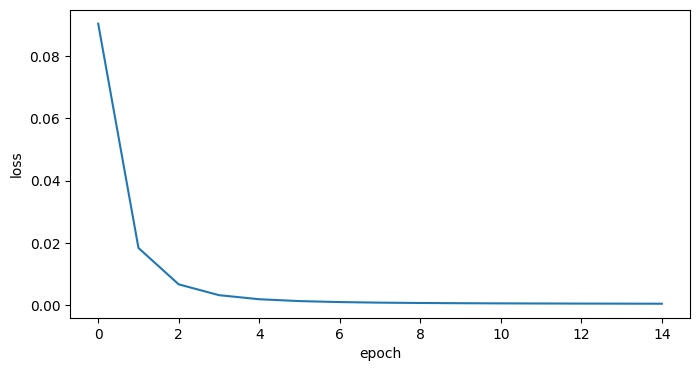

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [13]:
best_model = AutoEncoder().to(DEVICE)
best_model.load_state_dict(torch.load("./best_model.pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

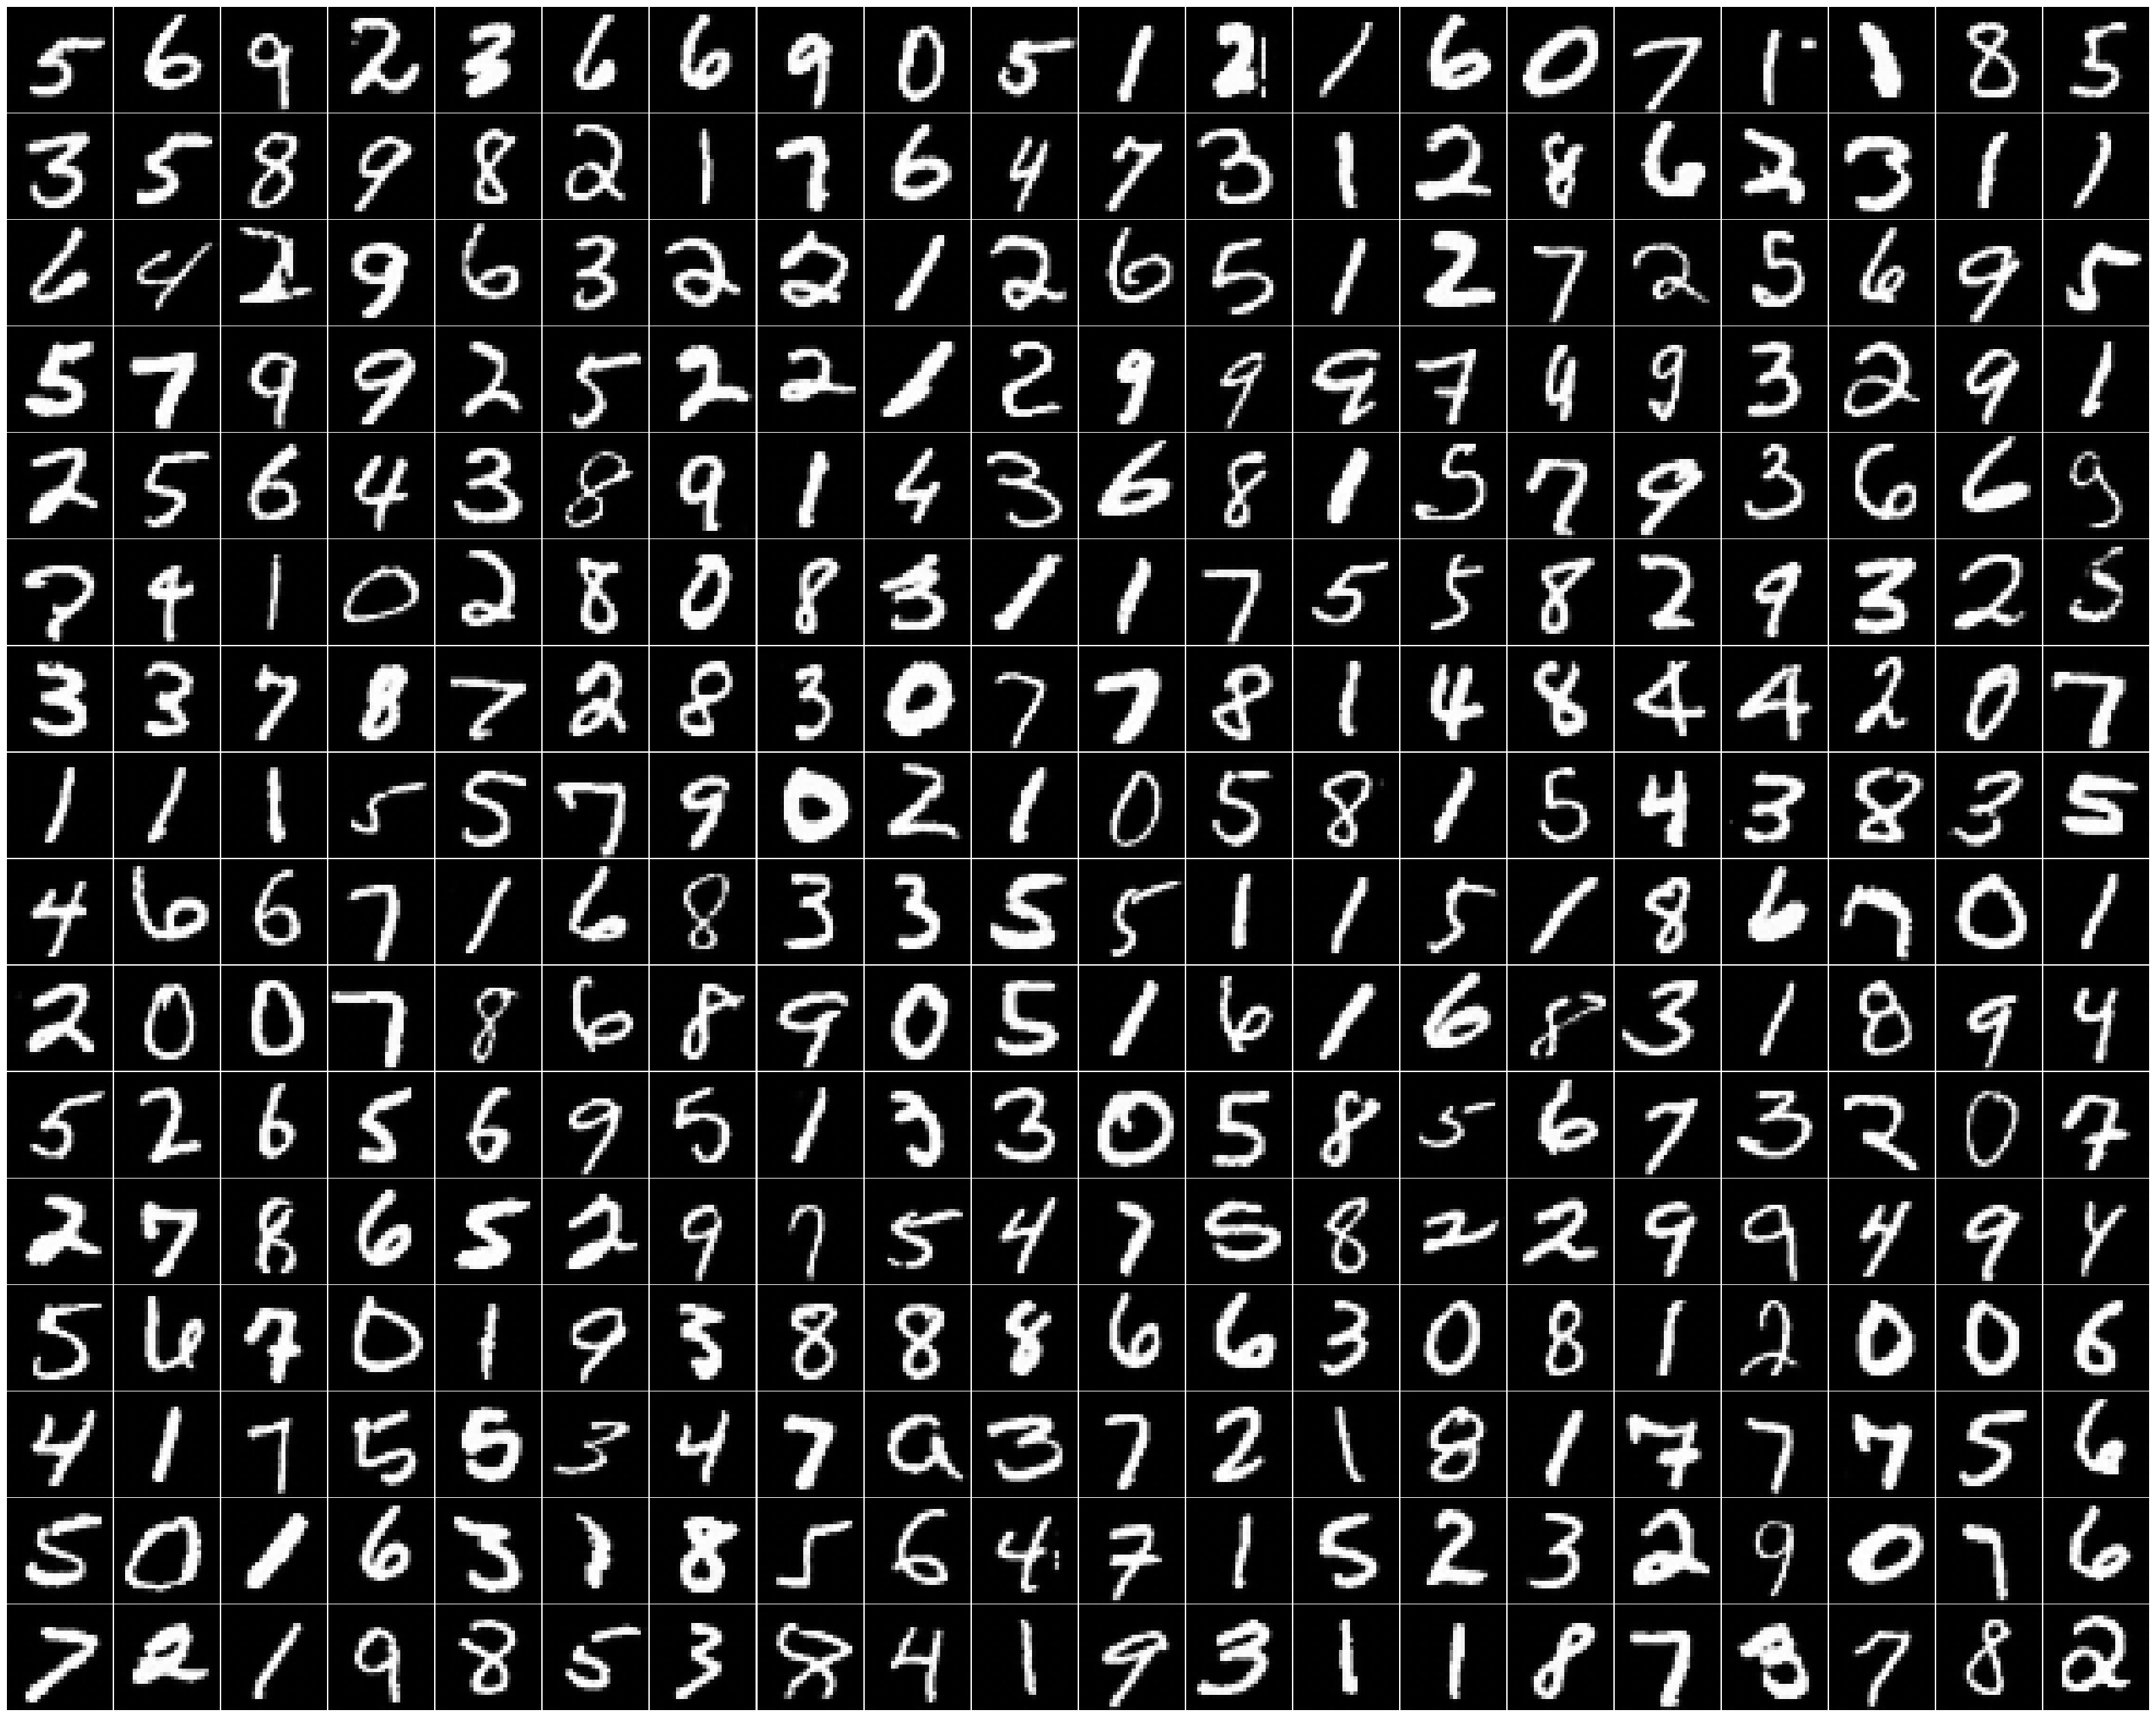

In [57]:
best_model.eval()

nrows, ncols = 16, 20
idx = np.random.choice(len(test_set), nrows * ncols,  replace=False)

with torch.no_grad():
    fig, axes = plt.subplots(nrows, ncols, figsize=(40, 32))
    for i, ax in zip(idx, axes.flatten()):
        img, _ = test_set.__getitem__(i)
        img = img.unsqueeze(0).to(DEVICE)
        out, _ = best_model(img)
        out = out.squeeze(0).cpu().permute(1, 2, 0)
        ax.imshow(out, cmap="gray")
        ax.axis(False)

    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

In [68]:
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = images.to(DEVICE)
        _, latent = best_model(images)
        latent_vectors.extend(latent.cpu())
        labels.extend(targets)

100%|██████████| 200/200 [00:01<00:00, 105.37it/s]


In [69]:
latent_2d = TSNE(n_components=2).fit_transform(np.array(latent_vectors))

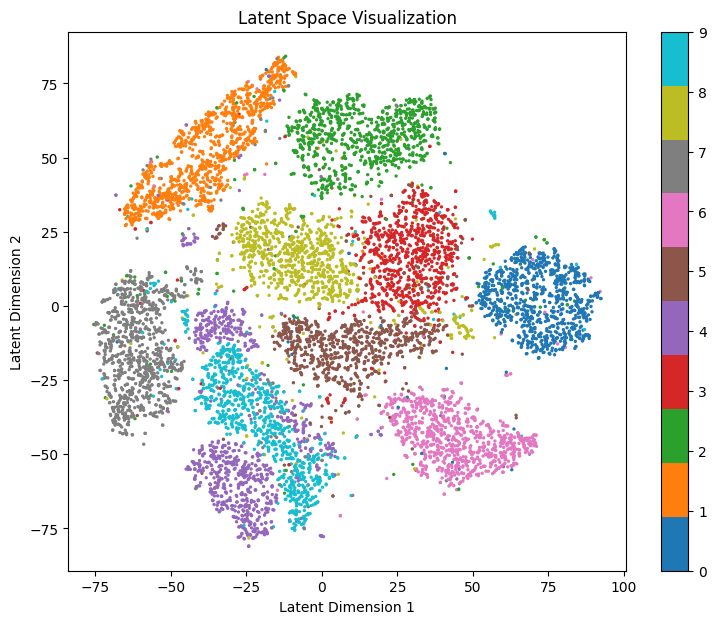

In [70]:
plt.figure(figsize=(9, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()